In [31]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

In [ ]:
class Flatten(torch.nn.Module): # 4D -> 2D로 계산하기
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
# (배치 수, 채널 수, 이미지 너비, 이미지 높이) -> (배치 수, 채널 수*이미지 너비*이미지 높이)

In [ ]:
class Deflatten(nn.Module): # 2D -> 4D로 계산하기

    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k

    def forward(self, x):
        s = x.size()

        # 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이
        # 벡터 사이즈 = 채널 수*이미지 사이즈**2
        # 이미지 사이즈 = (벡터 사이즈//채널 수)**.5
        feature_size = int((s[1] // self.k) ** .5)

        return x.view(s[0], self.k,feature_size, feature_size)
# (배치 수, 채널 수*이미지 너비*이미지 높이) -> (배치 수, 채널 수, 이미지 너비, 이미지 높이)

In [ ]:
nn.ConvTranspose2d?
# image upsampling에 사용
# 저해상도 이미지를 고해상도 이미지로 변환하는 작업
# 입력 이미지의 크기를 늘리면서
# 이미지의 디테일을 유지할 수 있다

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2),
                        nn.ReLU(),
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(),
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, 10),
                        nn.ReLU()
        )

        # ConvTranspose2d
        # 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
        # 출력 된 벡터는 행렬 형태로 변환한다.
        self.decoder = nn.Sequential(
                        nn.Linear(10, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1),
                        # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )

    def forward(self, x):

        encoded = self.encoder(x)
        # print(f'Encoded : {encoded.shape}') Encoded : torch.Size([50, 10])

        decoded = self.decoder(encoded)
        # print(f'Decoded : {decoded.shape}') Decoded : torch.Size([50, 1, 28, 28])

        return decoded

In [33]:
model = Autoencoder().to(device)

In [34]:
# pip install torchsummary

In [35]:
from torchsummary import summary

In [42]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
              ReLU-2           [-1, 16, 13, 13]               0
            Conv2d-3             [-1, 32, 6, 6]           4,640
              ReLU-4             [-1, 32, 6, 6]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
              ReLU-6             [-1, 64, 4, 4]               0
           Flatten-7                 [-1, 1024]               0
            Linear-8                   [-1, 10]          10,250
              ReLU-9                   [-1, 10]               0
           Linear-10                 [-1, 1024]          11,264
             ReLU-11                 [-1, 1024]               0
        Deflatten-12             [-1, 64, 4, 4]               0
  ConvTranspose2d-13             [-1, 32, 6, 6]          18,464
             ReLU-14             [-1, 3

In [ ]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=1024, out_features=10, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Deflatten()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (8): Sigmoid()
  )
)

In [ ]:
model.children
# 모델의 모든 레이어를 반환
# 모델을 평가할 때 사용

<bound method Module.children of Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=1024, out_features=10, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Deflatten()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (8): Sigmoid()
  )
)>

In [ ]:
model.parameters
# 모델의 모든 가중치를 반환
# 모델을 학습할 때 사용

<bound method Module.parameters of Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten()
    (7): Linear(in_features=1024, out_features=10, bias=True)
    (8): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1024, bias=True)
    (1): ReLU()
    (2): Deflatten()
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (8): Sigmoid()
  )
)>

In [ ]:
model.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'encoder.7.weight', 'encoder.7.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.3.weight', 'decoder.3.bias', 'decoder.5.weight', 'decoder.5.bias', 'decoder.7.weight', 'decoder.7.bias'])

In [ ]:
model.state_dict()['encoder.0.weight'].shape, model.state_dict()['encoder.0.bias']

(torch.Size([16, 1, 3, 3]),
 tensor([ 0.1478, -0.1575,  0.3111, -0.2770,  0.0414,  0.1606,  0.2856,  0.2092,
          0.0252,  0.0306,  0.3045,  0.1681, -0.2973,  0.2998,  0.2111, -0.0186],
        device='cuda:0'))

In [ ]:
model.state_dict()['decoder.0.weight'].shape, model.state_dict()['decoder.0.bias']

(torch.Size([1024, 10]),
 tensor([-0.1378, -0.3101,  0.1210,  ...,  0.2941,  0.1949, -0.2617],
        device='cuda:0'))

In [ ]:
def normalize_output(img):
    img = (img - img.min()) / (img.max() - img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs)

            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비
    rows = 5 # 시각화 전체 높이

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze()) # 1채널인 경우 2로 변환
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns * rows + 1):
        img = reconstructed_samples[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [ ]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    cost = running_loss / len(trainloader)

    if epoch % 10 == 0:
        print('[%d] loss: %.3f' %(epoch + 1, cost))

[1] loss: 0.091
[11] loss: 0.022
[21] loss: 0.021
[31] loss: 0.020
[41] loss: 0.020
[51] loss: 0.019


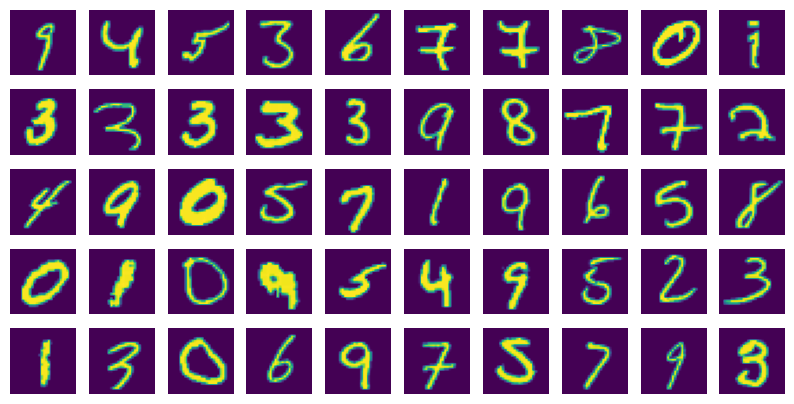

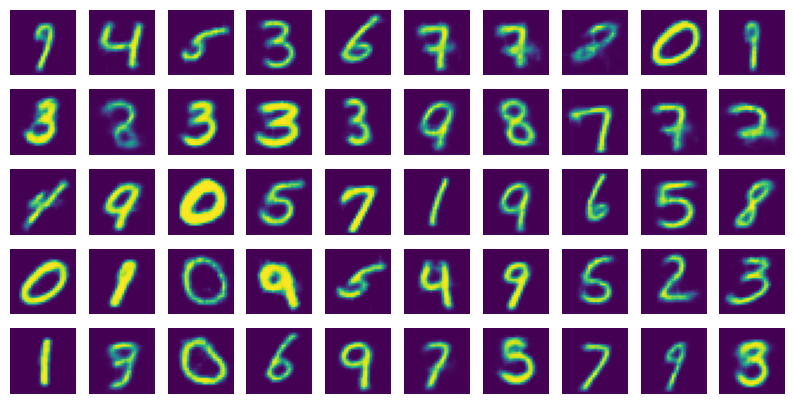

In [ ]:
check_plot()

In [ ]:
def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs)

            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비
    rows = 5 # 시각화 전체 높이

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        # plt.imshow(img.squeeze()) # 1채널인 경우 2로 변환
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns * rows + 1):
        img = reconstructed_samples[i - 1]
        fig.add_subplot(rows, columns, i)
        # plt.imshow(img.squeeze())
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

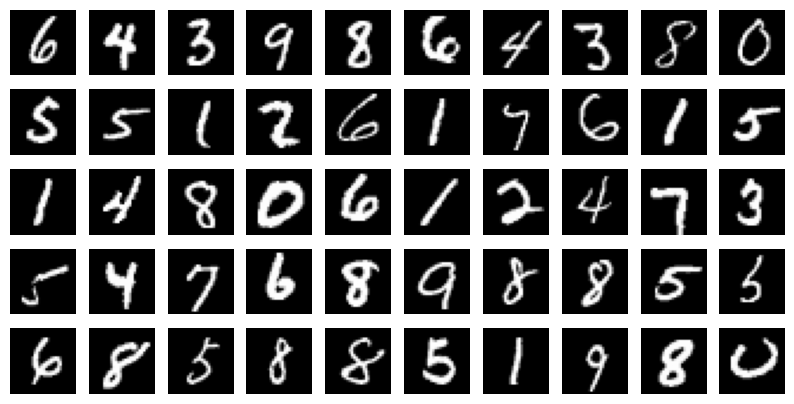

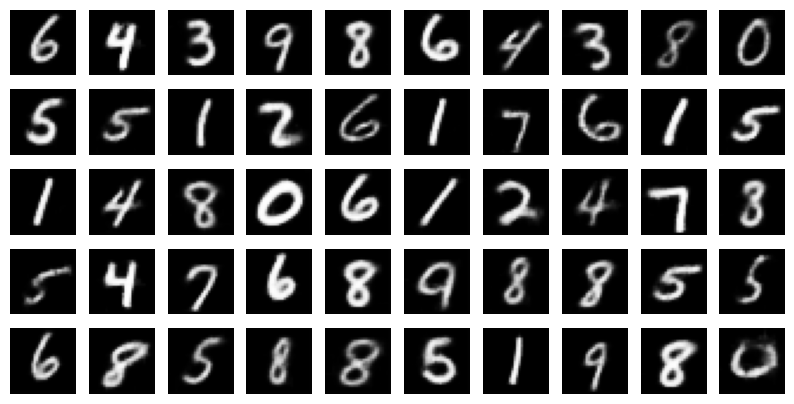

In [ ]:
check_plot()

In [ ]:
params = next(iter(model.parameters()))

In [ ]:
len(params)

16

In [ ]:
params[0]

tensor([[[ 0.0541, -0.1331,  0.0908],
         [ 0.2035, -0.0458, -0.1258],
         [-0.1961,  0.0798,  0.1022]]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.0541, -0.1331,  0.0908],
          [ 0.2035, -0.0458, -0.1258],
          [-0.1961,  0.0798,  0.1022]]],


        [[[-0.0026,  0.1209,  0.1005],
          [ 0.0224,  0.0533, -0.0226],
          [-0.0643,  0.0319, -0.0019]]],


        [[[-0.0789,  0.0708,  0.1261],
          [-0.4883, -0.1482, -0.1201],
          [ 0.0560,  0.0582, -0.0989]]],


        [[[-0.1073,  0.2104, -0.1011],
          [-0.0479,  0.1610, -0.1360],
          [-0.0498,  0.1864, -0.1046]]],


        [[[ 0.0239,  0.0099,  0.0324],
          [ 0.0799,  0.1000,  0.1614],
          [ 0.1329,  0.0019,  0.0494]]],


        [[[-0.0633, -0.1269, -0.3544],
          [ 0.0736,  0.0239, -0.1140],
          [ 0.1236, -0.0505, -0.5348]]],


        [[[ 0.0969,  0.0289, -0.0994],
          [ 0.0752, -0.1092, -0.0528],
          [ 0.0595,  0.0724, -0.0431]]],


        [[[ 0.1340, -0.1030, -0.0997],
          [ 0.1422,  0.0035, -0.1263],
          [ 0.1375, -0.1921, -0.0111]]],


        [[

In [ ]:
for child in model.children():
    print(child)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=1024, out_features=10, bias=True)
  (8): ReLU()
)
Sequential(
  (0): Linear(in_features=10, out_features=1024, bias=True)
  (1): ReLU()
  (2): Deflatten()
  (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (6): ReLU()
  (7): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
  (8): Sigmoid()
)
